In [30]:
# Authors: Daichi Yoshikawa <daichi.yoshikawa@gmail.com>
# License: BSD 3 clause

# This file is going to be merged with nn_utils module.

from __future__ import absolute_import

import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.stride_tricks import as_strided

In [78]:
def pad_img(img, pad_rows, pad_cols):
    """Returns padded matrix which represents image.

    1d matrix is not supported.
    Shape must be in forms of (***, ***, ... , ***, rows, cols),
    such as (rows, cols), (channels, rows, cols),
    or (batch size, channels, rows, cols), etc.

    Arguments
    ---------
    img : np.array
        Image matrix in 2 or more dimensional array.
        This array is not exposed to side effect.
    pad_rows : int or tuple (pad_upper, pad_lower)
        Number of pad in direction of rows.
        If tuple, the first entry is a number of pad in upper side
        and the second one is that in lower side.
    pad_cols : int or tuple (pad_left, pad_right)
        Number of pad in direction of cols.
        If tuple, the first entry is a number of pad in left side
        and the second one is that in right side.

    Returns
    -------
    np.array
        The resulting matrix, that is, padded matrix.
    """
    if (img.ndim < 2):
        msg = '1d array is not supported.'
        raise RuntimeError(msg)

    if np.prod(pad) == 0:
        return img

    npad = ()
    for i in range(img.ndim - 2):
        npad = npad + ((0, 0),)

    if isinstance(pad_rows, tuple):
        npad = npad + ((pad_rows[0], pad_rows[1]),)
    else:
        npad = npad + ((pad_rows, pad_rows),)

    if isinstance(pad_cols, tuple):
        npad = npad + ((pad_cols[0], pad_cols[1]),)
    elif pad_cols:
        npad = npad + ((pad_cols, pad_cols),)

    return np.pad(img, pad_width=npad, mode='constant', constant_values=0)

In [126]:
def reshape_img(img):
    """Returns reshaped 4d matrix.

    im2col function assumes that input matrix is 4d (bathes, channels, rows, cols).
    This function helps im2col by reshaping the matrix properly.
    If matrix's dimension is more than 4, this throws exception.

    Arguments
    ---------
    img : np.array
        Matrix in 1-4d array.

    Returns
    -------
    np.array
        Matrix in 4d array.
    """
    if len(img.shape) == 1:
        return img.reshape(1, 1, 1, img.shape[0])
    elif len(img.shape) == 2:
        return img.reshape(1, 1, img.shape[0], img.shape[1])
    elif len(img.shape) == 3:
        return img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    elif len(img.shape) > 4:
        msg = 'len(img.shape) must be <= 4.'
        raise RuntimeError(msg)
    return img


def get_remainders_of_filtering(rows, cols, f_rows, f_cols, strides):
    """Get remainders which resulted from applying filter.

    Combination of image size, filter size and stride size should be proper.
    If it is improper, remainders appear when filtering, that is,
    filter can't be applied to all pixels.
    The resulting remainders can be used to detect applicability of filter,
    or pad image to enable filtering.

    Arguments
    ---------
    img 
    """
    rem_r = (rows - f_rows) % strides[0]
    rem_c = (cols - f_cols) % strides[1]
    return rem_r, rem_c


def extend_img_for_filtering(img, rem_r, rem_c):
    """Extend(Pad) image matrix to enable it to be filtered properly.

    Based on remainders of filtering, pad image with 0s.
    This remainders are supposed to be gained through
    get_remainders_of_filtering function.

    Arguments
    ---------
    img : np.array
        Matrix in 2-4d array, whose shape is (rows, cols), (channels, rows, cols),
        or (batches, channels, rows, cols).
    rem_r : int
        Remainder in rows direction, which is derived from
        get_remainders_of_filtering function.
    rem_c : int
        Remainder in cols direction, which is derived from
        get_remainders_of_filtering function.

    Returns
    -------
    np.array
        Padded image in 2-4d array.
    """
    pad_r = (gap_r//2, gap_r - (gap_r//2))
    pad_c = (gap_c//2, gap_c - (gap_c//2))
    return pad_img(img, pad_r, pad_c)


def im2col(img, f_shape, pad, strides, force=False):
    """Convert 2-4d image matrix into a form which is proper for convolution.

    Convolutional neural network requires convolution and convolution requires
    filtering to 2d images.
    To do it with matrix computation, we have to convert original matrix,
    whose shape would be (rows, cols), (channels, rows, cols)
    or (batches, channels, rows, cols), into different form.

    Arguments
    ---------
    img : np.array
        Image matrix in 2-4d array, whose shape is (rows, cols),
        (channels, rows, cols), or (batches, channels, rows, cols).
    f_shape : tuple (rows, cols)
        Filter's shape.
    pad : tuple (rows, cols)
        Number of pad, which consists of 0s. If rows/cols shape is
        tuple (upper/left, lower/right), you can specify number of pad
        in upper/left or lower/right part of img.
        Eg. 
        img : 1, 2, 3
              4, 5, 6
        In case of pad=(1, 1) :
              0, 0, 0, 0, 0
              0, 1, 2, 3, 0
              0, 4, 5, 6, 0
              0, 0, 0, 0, 0
        In case of pad=((1, 2), (3, 2))
              0, 0, 0, 0, 0, 0, 0, 0
              0, 0, 0, 1, 2, 3, 0, 0
              0, 0, 0, 4, 5, 6, 0, 0
              0, 0, 0, 0, 0, 0, 0, 0
              0, 0, 0, 0, 0, 0, 0, 0
    strides : tuple (rows, cols)
        Stride size of filter in rows and cols direction.
    force : bool, default False
        Force conversion by padding in case of that
        combination of image shape, filter shape and strides is improper.
    """
    pimg = pad_img(reshape_img(img), pad[0], pad[1])

    batches, chs, rows, cols = pimg.shape
    f_rows, f_cols = f_shape
    gap_r, gap_c = get_remainders_of_filtering(rows, cols, f_rows, f_cols, strides)

    if (gap_r > 0) or (gap_c > 0):
        if force:
            pimg = extend_img_for_filtering(pimg, gap_r, gap_c)
            batches, chs, rows, cols = pimg.shape
        else:
            msg = 'Filter cannot be applied to image with the strides.\n'\
                + 'Image shape (with pad) : ' + str((rows, cols)) + '\n'\
                + 'Filter shape : ' + str((f_rows, f_cols)) + '\n'\
                + 'Strides : ' + str(strides)
            raise RuntimeError(msg)

    st_batch, st_ch, st_r, st_c = pimg.strides
    f_st_r = st_r * strides[0]
    f_st_c = st_c * strides[1]
    dst_strides = (st_batch, st_ch, f_st_r, f_st_c, st_r, st_c)

    dst_rows = (rows - f_rows) // strides[0] + 1
    dst_cols = (cols - f_cols) // strides[1] + 1
    dst_shape = (batches, chs, dst_rows, dst_cols, f_rows, f_cols)

    dst_img = as_strided(pimg, shape=dst_shape, strides=dst_strides)
    dst_img = dst_img.transpose(0, 2, 3, 1, 4, 5).reshape(batches, dst_rows*dst_cols, chs*f_rows*f_cols)

    return dst_img

In [129]:
img = np.arange(216).reshape(2, 3, 6, 6).astype(np.float32)

# Arguments
f_shape = (3, 3)
pad = (0, 0)
strides = (1, 1)
force = True

conv_img = im2col(img, f_shape, pad, strides, force)
conv_img.shape, conv_img

((2, 16, 27),
 array([[[   0.,    1.,    2.,    6.,    7.,    8.,   12.,   13.,   14.,
            36.,   37.,   38.,   42.,   43.,   44.,   48.,   49.,   50.,
            72.,   73.,   74.,   78.,   79.,   80.,   84.,   85.,   86.],
         [   1.,    2.,    3.,    7.,    8.,    9.,   13.,   14.,   15.,
            37.,   38.,   39.,   43.,   44.,   45.,   49.,   50.,   51.,
            73.,   74.,   75.,   79.,   80.,   81.,   85.,   86.,   87.],
         [   2.,    3.,    4.,    8.,    9.,   10.,   14.,   15.,   16.,
            38.,   39.,   40.,   44.,   45.,   46.,   50.,   51.,   52.,
            74.,   75.,   76.,   80.,   81.,   82.,   86.,   87.,   88.],
         [   3.,    4.,    5.,    9.,   10.,   11.,   15.,   16.,   17.,
            39.,   40.,   41.,   45.,   46.,   47.,   51.,   52.,   53.,
            75.,   76.,   77.,   81.,   82.,   83.,   87.,   88.,   89.],
         [   6.,    7.,    8.,   12.,   13.,   14.,   18.,   19.,   20.,
            42.,   43.,   44.,   

(2, 3, 6, 6) (432, 144, 24, 4)
[[[[   0.    1.    2.    3.    4.    5.]
   [   6.    7.    8.    9.   10.   11.]
   [  12.   13.   14.   15.   16.   17.]
   [  18.   19.   20.   21.   22.   23.]
   [  24.   25.   26.   27.   28.   29.]
   [  30.   31.   32.   33.   34.   35.]]

  [[  36.   37.   38.   39.   40.   41.]
   [  42.   43.   44.   45.   46.   47.]
   [  48.   49.   50.   51.   52.   53.]
   [  54.   55.   56.   57.   58.   59.]
   [  60.   61.   62.   63.   64.   65.]
   [  66.   67.   68.   69.   70.   71.]]

  [[  72.   73.   74.   75.   76.   77.]
   [  78.   79.   80.   81.   82.   83.]
   [  84.   85.   86.   87.   88.   89.]
   [  90.   91.   92.   93.   94.   95.]
   [  96.   97.   98.   99.  100.  101.]
   [ 102.  103.  104.  105.  106.  107.]]]


 [[[ 108.  109.  110.  111.  112.  113.]
   [ 114.  115.  116.  117.  118.  119.]
   [ 120.  121.  122.  123.  124.  125.]
   [ 126.  127.  128.  129.  130.  131.]
   [ 132.  133.  134.  135.  136.  137.]
   [ 138.  139.  1

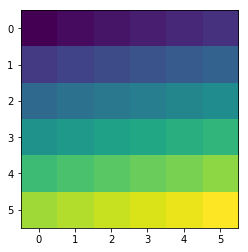

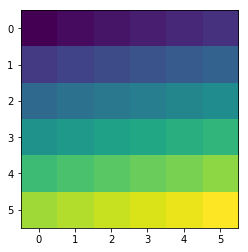

In [112]:
img = np.arange(216).reshape(2, 3, 6, 6).astype(np.float32)



# im2col
img = reshape_img(img)
pimg = pad_img(img, pad[0], pad[1])

batches, chs, rows, cols = pimg.shape
f_rows, f_cols = f_shape
gap_r, gap_c = get_remainders_of_filtering(rows, cols, f_rows, f_cols, strides)

if (gap_r > 0) or (gap_c > 0):
    if force:
        pimg = extend_img_for_filtering(pimg, gap_r, gap_c)
        batches, chs, rows, cols = pimg.shape
    else:
        msg = 'Filter cannot be applied to image with the strides.\n'\
            + 'Image shape (with pad) : ' + str((rows, cols)) + '\n'\
            + 'Filter shape : ' + str((f_rows, f_cols)) + '\n'\
            + 'Strides : ' + str(strides)
        raise RuntimeError(msg)

print(img.shape, img.strides)
print(img)
print('')
print(pimg.shape, pimg.strides)
print(pimg)
plt.imshow(img[0][0])
plt.show()
plt.imshow(pimg[0][0])
plt.show()

In [118]:
f_st_r = st_r * strides[0]
f_st_c = st_c * strides[1]

dst_rows = (rows - f_rows) // strides[0] + 1
dst_cols = (cols - f_cols) // strides[1] + 1
dst_shape = (batches, chs, dst_rows, dst_cols, f_rows, f_cols)

st_batch, st_ch, st_r, st_c = pimg.strides

dst_strides = (st_batch, st_ch, f_st_r, f_st_c, st_r, st_c)
dst_img = as_strided(pimg, shape=dst_shape, strides=dst_strides)
dst_img = dst_img.transpose(0, 2, 3, 1, 4, 5).reshape(batches, dst_rows*dst_cols, chs*f_rows*f_cols)

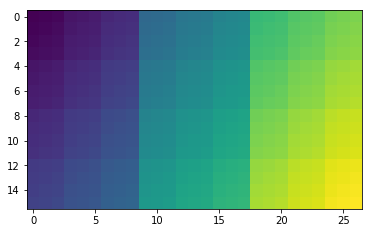

In [119]:
plt.imshow(dst_img[0])
plt.show()

In [ ]:
def im2col(img, window_, pad=(0, 0), strides=(1, 1)):
    if len(img.shape) == 2:
        img = img.reshape(1, 1, img.shape[0], img.shape[1])
    elif len(img.shape) == 3:
        img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

    return img

In [ ]:
"""
a = np.array([
    [1, 2, 3, 7, 8, 9, 13, 14, 15],
    [2, 3, 4, 8, 9, 10, 14, 15, 16],
    [3, 4, 5, 9, 10, 11, 15, 16, 17],
    [4, 5, 6, 10, 11, 12, 16, 17, 18],
    [7, 8, 9, 13, 14, 15, 19, 20, 21],
    [8, 9, 10, 14, 15, 16, 20, 21, 22],
    [9, 10, 11, 15, 16, 17, 21, 22, 23],
    [10, 11, 12, 16, 17, 18, 22, 23, 24],
    [13, 14, 15, 19, 20, 21, 25, 26, 27],
    [14, 15, 16, 20, 21, 22, 26, 27, 28],
    [15, 16, 17, 21, 22, 23, 27, 28, 29],
    [16, 17, 18, 22, 23, 24, 28, 29, 30],
    [19, 20, 21, 25, 26, 27, 31, 32, 33],
    [20, 21, 22, 26, 27, 28, 32, 33, 34],
    [21, 22, 23, 27, 28, 29, 33, 34, 35],
    [22, 23, 24, 28, 29, 30, 34, 35, 36]
])
a
"""

In [3]:
"""
oh = 4
ow = 4
fh = 3
fw = 3
print(np.arange(0, oh*ow))
print('')
print(np.arange(0, oh*ow).reshape(oh, -1)[::fh, ::fw])
row_indices = np.arange(0, oh*ow).reshape(oh, -1)[::fh, ::fw].reshape(1, -1)[0, :]
a[row_indices, :] # a[[0, 3, 12, 15], :]
"""

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]

[[ 0  3]
 [12 15]]


array([[ 1,  2,  3,  7,  8,  9, 13, 14, 15],
       [ 4,  5,  6, 10, 11, 12, 16, 17, 18],
       [19, 20, 21, 25, 26, 27, 31, 32, 33],
       [22, 23, 24, 28, 29, 30, 34, 35, 36]])

In [4]:
"""
h = 6
w = 6

a2 = a[row_indices, :]
a3 = a2.reshape(h//fh, w//fw, fh, fw)
a3.transpose(0, 2, 1, 3).reshape(h, w)
"""

array([[ 1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12],
       [13, 14, 15, 16, 17, 18],
       [19, 20, 21, 22, 23, 24],
       [25, 26, 27, 28, 29, 30],
       [31, 32, 33, 34, 35, 36]])

In [112]:
def pad_image(image, pad=(0, 0)):
    shape_len = len(image.shape)
    
    if shape_len == 2:
        npad = ((pad[0], pad[0]), (pad[1], pad[1]))
    elif shape_len == 3:
        npad = ((0, 0), (pad[0], pad[0]), (pad[1], pad[1]))
    elif shape_len == 4:
        npad = ((0, 0), (0, 0), (pad[0], pad[0]), (pad[1], pad[1]))
    elif shape_len == 5:
        npad = ((0, 0), (0, 0), (0, 0), (pad[0], pad[0]), (pad[1], pad[1]))
    else:
        raise RuntimeError('len(image.shape) > 5 or < 2.')
    return np.pad(image, pad_width=npad, mode='constant', constant_values=0)


def im2col(image, window_shape, pad=(0, 0), strides=(1, 1), ch_axis=0):
    def assert_strides(img_shape, win_shape, pad, strides):
        if (img_shape[0] - win_shape[0]) % strides[0] > 0:
            msg = 'Improper combination of image size, window size '\
                + 'and strides.\n'\
                + '(img_shape[0] - win_shape[0]) % strides[0] '\
                + 'must be 0.'
            raise RuntimeError(msg)
        if (img_shape[1] - win_shape[1]) % strides[1] > 0:
            msg = 'Improper combination of image size, window size '\
                + 'and strides.\n'\
                + '(img_shape[1] - win_shape[1]) % strides[1] '\
                + 'must be 0.'
            raise RuntimeError(msg)
    '''
    image.shape must be (batch_size, channels, rows, cos)
    window_shape must be (rows, cols)
    strides must be (stride_rows, stride_cols)
    '''
    assert_strides(image.shape, window_shape, pad, strides)    

    batch_sizes, channels, img_rows, img_cols = image.shape
    stride_per_batch, stride_per_channel, stride_per_row, stride_per_col\
            = image.strides
    win_rows, win_cols = window_shape
    
    dst_rows = (img_rows - win_rows) // strides[0] + 1
    dst_cols = (img_cols - win_cols) // strides[1] + 1

    # Byte size required to stride running window in row/col direction
    win_stride_per_row = stride_per_row * strides[0]
    win_stride_per_col = stride_per_col * strides[1]

    '''
    ---- How to decide shape ----
    Start from small part and consider bigger part later.
    
    Step 1. Put win_rows and win_cols as arguments
        Resulting image should have (win_rows, win_cols) size matrices
        as the smallest element. This small matrices are reshaped to
        (1, win_rows * win_cols) matrices later.
    Step 2. Put dst_rows and dst_cols as arguments
        The number of the small matrices, we considered at step 1,
        is dst_rows * dst_cols.
    Step 3. Put channels
        One image for one channel has the above matrix, whose size
        is dst_rows * dst_cols and each row have (win_rows, win_cols)
        matrices. Now we consider N-channels.
    Step 4. Put batch_sizes
        Step 3 is for a single image. We use multiple images
        for batch process.
        
    ---- How to decide strides ----
    All you need to do is put stride size which correspond with shape,
    that is, batch_size, channels, dst_rows, dst_cols, win_rows, win_cols.
    '''
    shape = (batch_sizes, channels, dst_rows, dst_cols, win_rows, win_cols)    
    strides = (
            stride_per_batch, stride_per_channel,
            win_stride_per_row, win_stride_per_col,
            stride_per_row, stride_per_col)
    
    dst = as_strided(image, shape=shape, strides=strides)
    '''
    Firstly we have to switch dimensions to reshape dst matrix properly.
    Here are meanings of indices.
    0: Batch size, 
    1: channels,
    2: dst_rows,
    3: dst_cols,
    4: win_rows,
    5: win_cols
    
    We align N-channels data in the same row.
    So we need to move "channels dimension" right after dst_rows and dst_cols.
    By this, we can put (win_rows, win_cols)-sized matrices for N-channels
    to the same dimension later.
    '''
    
    if ch_axis == 0:
        dst_col = win_rows * win_cols
        return dst.reshape(batch_size, channels, -1, dst_col)
    else:
        dst_col = win_rows * win_cols * channels
        return dst.transpose(0, 2, 3, 1, 4, 5).reshape(batch_size, -1, dst_col)


def col2im(mat, window_shape, batch_size, channels, h, w, strides=(1, 1), ch_axis=1):
    win_h, win_w = window_shape

    row_indices = np.arange(0, oh*ow).reshape(oh, -1)[::win_h, ::win_w]
    row_indices = row_indices.reshape(1, -1)[0, :]
    image = mat[:, row_indices, :].reshape(batch_size, 4, channels, win_h*win_w)
    image = image.transpose(0, 2, 1, 3)
    image = image.reshape(batch_size, channels, h//win_h, w//win_w, win_h, win_w)
    image = image.transpose(0, 1, 2, 4, 3, 5).reshape(batch_size, channels, h, w)

    return image


def flatten(img):
    batch_size, channels, rows, cols = img.shape
    return img.reshape(batch_size, channels*rows*cols)

In [113]:
"""
batch_size = 5
channels = 3
img_h = 4
img_w = 4
total = img_h * img_w * channels * batch_size
image = np.arange(total).reshape(batch_size, channels, img_h, img_w)
window_shape = (2, 2)
pad = (0, 0)
strides = (1, 1)
image = pad_image(image, pad)
col = im2col(image, window_shape, pad, strides, ch_axis=1)
col
#col.max(axis=3)
"""

array([[[  0,   1,   4,   5,  16,  17,  20,  21,  32,  33,  36,  37],
        [  1,   2,   5,   6,  17,  18,  21,  22,  33,  34,  37,  38],
        [  2,   3,   6,   7,  18,  19,  22,  23,  34,  35,  38,  39],
        [  4,   5,   8,   9,  20,  21,  24,  25,  36,  37,  40,  41],
        [  5,   6,   9,  10,  21,  22,  25,  26,  37,  38,  41,  42],
        [  6,   7,  10,  11,  22,  23,  26,  27,  38,  39,  42,  43],
        [  8,   9,  12,  13,  24,  25,  28,  29,  40,  41,  44,  45],
        [  9,  10,  13,  14,  25,  26,  29,  30,  41,  42,  45,  46],
        [ 10,  11,  14,  15,  26,  27,  30,  31,  42,  43,  46,  47]],

       [[ 48,  49,  52,  53,  64,  65,  68,  69,  80,  81,  84,  85],
        [ 49,  50,  53,  54,  65,  66,  69,  70,  81,  82,  85,  86],
        [ 50,  51,  54,  55,  66,  67,  70,  71,  82,  83,  86,  87],
        [ 52,  53,  56,  57,  68,  69,  72,  73,  84,  85,  88,  89],
        [ 53,  54,  57,  58,  69,  70,  73,  74,  85,  86,  89,  90],
        [ 54,  55,

In [114]:
#mat, window_shape, batch_size, channels, h, w, pad=(0, 0), strides=(1, 1), ch_axis=1
#col2im(col, window_shape, batch_size, channels, image.shape[2], image.shape[3], strides, ch_axis=1)

array([[[[  0,   1,   2,   3],
         [  4,   5,   6,   7],
         [  8,   9,  10,  11],
         [ 12,  13,  14,  15]],

        [[ 16,  17,  18,  19],
         [ 20,  21,  22,  23],
         [ 24,  25,  26,  27],
         [ 28,  29,  30,  31]],

        [[ 32,  33,  34,  35],
         [ 36,  37,  38,  39],
         [ 40,  41,  42,  43],
         [ 44,  45,  46,  47]]],


       [[[ 48,  49,  50,  51],
         [ 52,  53,  54,  55],
         [ 56,  57,  58,  59],
         [ 60,  61,  62,  63]],

        [[ 64,  65,  66,  67],
         [ 68,  69,  70,  71],
         [ 72,  73,  74,  75],
         [ 76,  77,  78,  79]],

        [[ 80,  81,  82,  83],
         [ 84,  85,  86,  87],
         [ 88,  89,  90,  91],
         [ 92,  93,  94,  95]]],


       [[[ 96,  97,  98,  99],
         [100, 101, 102, 103],
         [104, 105, 106, 107],
         [108, 109, 110, 111]],

        [[112, 113, 114, 115],
         [116, 117, 118, 119],
         [120, 121, 122, 123],
         [124, 125, 1

array([192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239])

In [32]:
#col2im(col, window_shape, batch_size, channels, img_h, img_w, pad, strides, ch_axis=1)

ValueError: cannot reshape array of size 4800 into shape (100,3,14,14,2,2)

In [8]:
"""
oh = 3
ow = 3
fh = 2
fw = 2
print(np.arange(0, oh*ow))
print('')
print(np.arange(0, oh*ow).reshape(oh, -1))
print('')
row_indices = np.arange(0, oh*ow).reshape(oh, -1)[::fh, ::fw].reshape(1, -1)[0, :]
print(row_indices)
col[:, row_indices, :]
"""

#a[row_indices, :] # a[[0, 3, 12, 15], :]

[0 1 2 3 4 5 6 7 8]

[[0 1 2]
 [3 4 5]
 [6 7 8]]

[0 2 6 8]


array([[[  0,   1,   4,   5,  16,  17,  20,  21,  32,  33,  36,  37],
        [  2,   3,   6,   7,  18,  19,  22,  23,  34,  35,  38,  39],
        [  8,   9,  12,  13,  24,  25,  28,  29,  40,  41,  44,  45],
        [ 10,  11,  14,  15,  26,  27,  30,  31,  42,  43,  46,  47]],

       [[ 48,  49,  52,  53,  64,  65,  68,  69,  80,  81,  84,  85],
        [ 50,  51,  54,  55,  66,  67,  70,  71,  82,  83,  86,  87],
        [ 56,  57,  60,  61,  72,  73,  76,  77,  88,  89,  92,  93],
        [ 58,  59,  62,  63,  74,  75,  78,  79,  90,  91,  94,  95]],

       [[ 96,  97, 100, 101, 112, 113, 116, 117, 128, 129, 132, 133],
        [ 98,  99, 102, 103, 114, 115, 118, 119, 130, 131, 134, 135],
        [104, 105, 108, 109, 120, 121, 124, 125, 136, 137, 140, 141],
        [106, 107, 110, 111, 122, 123, 126, 127, 138, 139, 142, 143]],

       [[144, 145, 148, 149, 160, 161, 164, 165, 176, 177, 180, 181],
        [146, 147, 150, 151, 162, 163, 166, 167, 178, 179, 182, 183],
        [152, 

In [9]:
###############################################################################



SyntaxError: unexpected EOF while parsing (<ipython-input-9-cdafb783e987>, line 4)

In [10]:
"""
h = 4
w = 4

col2 = col[:, row_indices, :]
print(col2.shape)
#print(col2)
col3 = col2.reshape(batch_size, 4, channels, fh*fw)
col4 = col3.transpose(0, 2, 1, 3)
print(col4[0].shape)
col5 = col4.reshape(batch_size, channels, h//fh, w//fw, fh, fw).transpose(0, 1, 2, 4, 3, 5).reshape(batch_size, channels, h, w)
print(col5.shape)
col5
"""
#col4[0][0].reshape(h//fh, w//fw, fh, fw).transpose(0, 2, 1, 3).reshape(h, w)
#col2.reshape(batch_size, 4, -1)

#print(col2.shape)
#col3 = col2.reshape(batch_size, channels, h//fh, w//fw, fh, fw)
#print(col3.shape)
#col4 = col3.transpose(0, 1, 2, 4, 3, 5).reshape(batch_size, channels, h, w)
#print(col4.shape)
#col3
#a3.transpose(0, 2, 1, 3).reshape(h, w)

(5, 4, 12)
(3, 4, 4)
(5, 3, 4, 4)


array([[[[  0,   1,   2,   3],
         [  4,   5,   6,   7],
         [  8,   9,  10,  11],
         [ 12,  13,  14,  15]],

        [[ 16,  17,  18,  19],
         [ 20,  21,  22,  23],
         [ 24,  25,  26,  27],
         [ 28,  29,  30,  31]],

        [[ 32,  33,  34,  35],
         [ 36,  37,  38,  39],
         [ 40,  41,  42,  43],
         [ 44,  45,  46,  47]]],


       [[[ 48,  49,  50,  51],
         [ 52,  53,  54,  55],
         [ 56,  57,  58,  59],
         [ 60,  61,  62,  63]],

        [[ 64,  65,  66,  67],
         [ 68,  69,  70,  71],
         [ 72,  73,  74,  75],
         [ 76,  77,  78,  79]],

        [[ 80,  81,  82,  83],
         [ 84,  85,  86,  87],
         [ 88,  89,  90,  91],
         [ 92,  93,  94,  95]]],


       [[[ 96,  97,  98,  99],
         [100, 101, 102, 103],
         [104, 105, 106, 107],
         [108, 109, 110, 111]],

        [[112, 113, 114, 115],
         [116, 117, 118, 119],
         [120, 121, 122, 123],
         [124, 125, 1

In [11]:
#np.array([1, 2, 3, 4, 5, 6]).reshape(2, 3)

array([[1, 2, 3],
       [4, 5, 6]])

In [12]:
"""
window_num = 8
win_total = window_shape[0] * window_shape[1] * channels * window_num
#window = np.arange(win_total).reshape(window_num, channels, window_shape[0], window_shape[1])
window = np.ones((window_num, channels, window_shape[0], window_shape[1]))
window.shape
"""

(8, 3, 2, 2)

In [106]:
#w = window.transpose(1, 2, 3, 0).reshape(window_shape[0] * window_shape[1] * channels, -1)
#print(w.shape)
#w

In [114]:
"""
fire = np.dot(
        col,
        window.transpose(1, 2, 3, 0).reshape(window_shape[0] * window_shape[1] * channels, -1)
)
print(fire.shape)

oh = 3
ow = 3

fire = fire.transpose(0, 2, 1).reshape(batch_size, window_num, oh, ow)
print(fire.shape)
fire[0]
"""

(5, 9, 8)
(5, 8, 3, 3)


array([[[ 222.,  234.,  246.],
        [ 270.,  282.,  294.],
        [ 318.,  330.,  342.]],

       [[ 222.,  234.,  246.],
        [ 270.,  282.,  294.],
        [ 318.,  330.,  342.]],

       [[ 222.,  234.,  246.],
        [ 270.,  282.,  294.],
        [ 318.,  330.,  342.]],

       [[ 222.,  234.,  246.],
        [ 270.,  282.,  294.],
        [ 318.,  330.,  342.]],

       [[ 222.,  234.,  246.],
        [ 270.,  282.,  294.],
        [ 318.,  330.,  342.]],

       [[ 222.,  234.,  246.],
        [ 270.,  282.,  294.],
        [ 318.,  330.,  342.]],

       [[ 222.,  234.,  246.],
        [ 270.,  282.,  294.],
        [ 318.,  330.,  342.]],

       [[ 222.,  234.,  246.],
        [ 270.,  282.,  294.],
        [ 318.,  330.,  342.]]])

In [113]:
#fire[2][0]

array([[ 1374.,  1386.,  1398.],
       [ 1422.,  1434.,  1446.],
       [ 1470.,  1482.,  1494.]])

In [94]:
#oh = 3
#ow = 3
#fire.shape

(1, 8, 9)

In [96]:
#fire.reshape(1, 8, 3, 3)

array([[[[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]],

        [[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]],

        [[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]],

        [[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]],

        [[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]],

        [[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]],

        [[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]],

        [[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]]]])

In [75]:
#oh = 3
#ow = 3
#fire2 = fire.T.reshape(1, -1, oh, ow)
#fire2 = fire.T.reshape(1, -1, oh, ow)

In [76]:
#fire2

array([[[[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]],

        [[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]],

        [[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]],

        [[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]],

        [[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]],

        [[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]],

        [[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]],

        [[ 222.,  234.,  246.],
         [ 270.,  282.,  294.],
         [ 318.,  330.,  342.]]]])

In [45]:
"""
batch_size = 1
channels = 1
img_h = 10
img_w = 10
total = img_h * img_w * channels * batch_size
image = np.arange(total).reshape(batch_size, channels, img_h, img_w)
window_shape = (2, 2)
pad = (0, 0)
strides = (1, 1)
conv_image = im2col(image, window_shape, pad, strides)
conv_image
"""

array([[[ 0,  1, 10, 11],
        [ 1,  2, 11, 12],
        [ 2,  3, 12, 13],
        [ 3,  4, 13, 14],
        [ 4,  5, 14, 15],
        [ 5,  6, 15, 16],
        [ 6,  7, 16, 17],
        [ 7,  8, 17, 18],
        [ 8,  9, 18, 19],
        [10, 11, 20, 21],
        [11, 12, 21, 22],
        [12, 13, 22, 23],
        [13, 14, 23, 24],
        [14, 15, 24, 25],
        [15, 16, 25, 26],
        [16, 17, 26, 27],
        [17, 18, 27, 28],
        [18, 19, 28, 29],
        [20, 21, 30, 31],
        [21, 22, 31, 32],
        [22, 23, 32, 33],
        [23, 24, 33, 34],
        [24, 25, 34, 35],
        [25, 26, 35, 36],
        [26, 27, 36, 37],
        [27, 28, 37, 38],
        [28, 29, 38, 39],
        [30, 31, 40, 41],
        [31, 32, 41, 42],
        [32, 33, 42, 43],
        [33, 34, 43, 44],
        [34, 35, 44, 45],
        [35, 36, 45, 46],
        [36, 37, 46, 47],
        [37, 38, 47, 48],
        [38, 39, 48, 49],
        [40, 41, 50, 51],
        [41, 42, 51, 52],
        [42,

In [44]:
"""
batch_size = 5
channels = 3
img_h = 10
img_w = 10
total = img_h * img_w * channels * batch_size
image = np.arange(total).reshape(batch_size, channels, img_h, img_w)
window_shape = (2, 2)
pad = (0, 0)
strides = (1, 1)
conv_image = im2col(image, window_shape, pad, strides)
conv_image
"""

array([[[  0,   1,  10,  11],
        [  1,   2,  11,  12],
        [  2,   3,  12,  13],
        ..., 
        [ 86,  87,  96,  97],
        [ 87,  88,  97,  98],
        [ 88,  89,  98,  99]],

       [[100, 101, 110, 111],
        [101, 102, 111, 112],
        [102, 103, 112, 113],
        ..., 
        [186, 187, 196, 197],
        [187, 188, 197, 198],
        [188, 189, 198, 199]],

       [[200, 201, 210, 211],
        [201, 202, 211, 212],
        [202, 203, 212, 213],
        ..., 
        [286, 287, 296, 297],
        [287, 288, 297, 298],
        [288, 289, 298, 299]],

       [[300, 301, 310, 311],
        [301, 302, 311, 312],
        [302, 303, 312, 313],
        ..., 
        [386, 387, 396, 397],
        [387, 388, 397, 398],
        [388, 389, 398, 399]],

       [[400, 401, 410, 411],
        [401, 402, 411, 412],
        [402, 403, 412, 413],
        ..., 
        [486, 487, 496, 497],
        [487, 488, 497, 498],
        [488, 489, 498, 499]]])

In [36]:
"""
batch_size = 5
channels = 3
img_h = 10
img_w = 10
total = img_h * img_w * channels * batch_size
image = np.arange(total).reshape(batch_size, channels, img_h, img_w)
window_shape = (2, 2)
pad = (1, 1)
strides = (1, 1)

image = pad_image(image, pad)
conv_image = im2col(image, window_shape, pad, strides)
conv_image[0][2]
"""

array([  0,   0,   1,   2,   0,   0, 101, 102,   0,   0, 201, 202])

In [42]:
"""
size = 60000
channels = 1
img_h = 28
img_w = 28
total = img_h * img_w * channels * size
image = np.arange(total).reshape(600, 100, channels, img_h, img_w)

pad = (1, 1)
image = pad_image(image, pad)
strides = (1, 1)
window_shape = (2, 2)

for i in range(600):
    conv_image = im2col(image[i], window_shape, pad, strides)
#    conv_image
"""

In [321]:
"""
x = np.arange(100).reshape(10, 10)
print(x.shape, x.strides)
print(x)
"""

(10, 10) (80, 8)
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]


In [357]:
"""
print(as_strided(x, shape=(2, 2), strides=(80, 8)))
print('')
print(as_strided(x, shape=(9, 2, 2), strides=(8, 80, 8)))
print('')
print(as_strided(x, shape=(9, 9, 2, 2), strides=(80, 8, 80, 8)))
"""

[[ 0  1]
 [10 11]]

[[[ 0  1]
  [10 11]]

 [[ 1  2]
  [11 12]]

 [[ 2  3]
  [12 13]]

 [[ 3  4]
  [13 14]]

 [[ 4  5]
  [14 15]]

 [[ 5  6]
  [15 16]]

 [[ 6  7]
  [16 17]]

 [[ 7  8]
  [17 18]]

 [[ 8  9]
  [18 19]]]

[[[[ 0  1]
   [10 11]]

  [[ 1  2]
   [11 12]]

  [[ 2  3]
   [12 13]]

  [[ 3  4]
   [13 14]]

  [[ 4  5]
   [14 15]]

  [[ 5  6]
   [15 16]]

  [[ 6  7]
   [16 17]]

  [[ 7  8]
   [17 18]]

  [[ 8  9]
   [18 19]]]


 [[[10 11]
   [20 21]]

  [[11 12]
   [21 22]]

  [[12 13]
   [22 23]]

  [[13 14]
   [23 24]]

  [[14 15]
   [24 25]]

  [[15 16]
   [25 26]]

  [[16 17]
   [26 27]]

  [[17 18]
   [27 28]]

  [[18 19]
   [28 29]]]


 [[[20 21]
   [30 31]]

  [[21 22]
   [31 32]]

  [[22 23]
   [32 33]]

  [[23 24]
   [33 34]]

  [[24 25]
   [34 35]]

  [[25 26]
   [35 36]]

  [[26 27]
   [36 37]]

  [[27 28]
   [37 38]]

  [[28 29]
   [38 39]]]


 [[[30 31]
   [40 41]]

  [[31 32]
   [41 42]]

  [[32 33]
   [42 43]]

  [[33 34]
   [43 44]]

  [[34 35]
   [44 45]]

  [[35 

In [360]:
"""
y = as_strided(x, shape=(9, 9, 2, 2), strides=(80, 8, 80, 8))
y.reshape(9 * 9, 2 * 2)
"""

array([[ 0,  1, 10, 11],
       [ 1,  2, 11, 12],
       [ 2,  3, 12, 13],
       [ 3,  4, 13, 14],
       [ 4,  5, 14, 15],
       [ 5,  6, 15, 16],
       [ 6,  7, 16, 17],
       [ 7,  8, 17, 18],
       [ 8,  9, 18, 19],
       [10, 11, 20, 21],
       [11, 12, 21, 22],
       [12, 13, 22, 23],
       [13, 14, 23, 24],
       [14, 15, 24, 25],
       [15, 16, 25, 26],
       [16, 17, 26, 27],
       [17, 18, 27, 28],
       [18, 19, 28, 29],
       [20, 21, 30, 31],
       [21, 22, 31, 32],
       [22, 23, 32, 33],
       [23, 24, 33, 34],
       [24, 25, 34, 35],
       [25, 26, 35, 36],
       [26, 27, 36, 37],
       [27, 28, 37, 38],
       [28, 29, 38, 39],
       [30, 31, 40, 41],
       [31, 32, 41, 42],
       [32, 33, 42, 43],
       [33, 34, 43, 44],
       [34, 35, 44, 45],
       [35, 36, 45, 46],
       [36, 37, 46, 47],
       [37, 38, 47, 48],
       [38, 39, 48, 49],
       [40, 41, 50, 51],
       [41, 42, 51, 52],
       [42, 43, 52, 53],
       [43, 44, 53, 54],


In [361]:
"""
# With Channels
x = np.arange(300).reshape(3, 10, 10)
print(x.shape, x.strides)
print(x)
print(as_strided(x, shape=(3, 9, 9, 2, 2), strides=(800, 80, 8, 80, 8)))
"""

(3, 10, 10) (800, 80, 8)
[[[  0   1   2   3   4   5   6   7   8   9]
  [ 10  11  12  13  14  15  16  17  18  19]
  [ 20  21  22  23  24  25  26  27  28  29]
  [ 30  31  32  33  34  35  36  37  38  39]
  [ 40  41  42  43  44  45  46  47  48  49]
  [ 50  51  52  53  54  55  56  57  58  59]
  [ 60  61  62  63  64  65  66  67  68  69]
  [ 70  71  72  73  74  75  76  77  78  79]
  [ 80  81  82  83  84  85  86  87  88  89]
  [ 90  91  92  93  94  95  96  97  98  99]]

 [[100 101 102 103 104 105 106 107 108 109]
  [110 111 112 113 114 115 116 117 118 119]
  [120 121 122 123 124 125 126 127 128 129]
  [130 131 132 133 134 135 136 137 138 139]
  [140 141 142 143 144 145 146 147 148 149]
  [150 151 152 153 154 155 156 157 158 159]
  [160 161 162 163 164 165 166 167 168 169]
  [170 171 172 173 174 175 176 177 178 179]
  [180 181 182 183 184 185 186 187 188 189]
  [190 191 192 193 194 195 196 197 198 199]]

 [[200 201 202 203 204 205 206 207 208 209]
  [210 211 212 213 214 215 216 217 218 219]
  [

In [363]:
"""
x = np.arange(1500).reshape(5, 3, 10, 10)
print(x.shape, x.strides)
print(x)
"""

(5, 3, 10, 10) (2400, 800, 80, 8)
[[[[   0    1    2 ...,    7    8    9]
   [  10   11   12 ...,   17   18   19]
   [  20   21   22 ...,   27   28   29]
   ..., 
   [  70   71   72 ...,   77   78   79]
   [  80   81   82 ...,   87   88   89]
   [  90   91   92 ...,   97   98   99]]

  [[ 100  101  102 ...,  107  108  109]
   [ 110  111  112 ...,  117  118  119]
   [ 120  121  122 ...,  127  128  129]
   ..., 
   [ 170  171  172 ...,  177  178  179]
   [ 180  181  182 ...,  187  188  189]
   [ 190  191  192 ...,  197  198  199]]

  [[ 200  201  202 ...,  207  208  209]
   [ 210  211  212 ...,  217  218  219]
   [ 220  221  222 ...,  227  228  229]
   ..., 
   [ 270  271  272 ...,  277  278  279]
   [ 280  281  282 ...,  287  288  289]
   [ 290  291  292 ...,  297  298  299]]]


 [[[ 300  301  302 ...,  307  308  309]
   [ 310  311  312 ...,  317  318  319]
   [ 320  321  322 ...,  327  328  329]
   ..., 
   [ 370  371  372 ...,  377  378  379]
   [ 380  381  382 ...,  387  388  389]
  

In [382]:
"""
y = as_strided(x, shape=(5, 3, 9, 9, 2, 2), strides=(2400, 800, 80, 8, 80, 8))

# 0   1   2      3      4         5
# bs, ch, new_h, new_w, filter_w, filter_h
ch = 3
new_h = 9
new_w = 9
win_h = 2
win_w = 2
batch_size = 5
z = y.transpose(0, 2, 3, 1, 4, 5).reshape(batch_size, -1, win_h*win_w*ch)
print(z.shape)
z
"""

(5, 81, 12)


array([[[   0,    1,   10, ...,  201,  210,  211],
        [   1,    2,   11, ...,  202,  211,  212],
        [   2,    3,   12, ...,  203,  212,  213],
        ..., 
        [  86,   87,   96, ...,  287,  296,  297],
        [  87,   88,   97, ...,  288,  297,  298],
        [  88,   89,   98, ...,  289,  298,  299]],

       [[ 300,  301,  310, ...,  501,  510,  511],
        [ 301,  302,  311, ...,  502,  511,  512],
        [ 302,  303,  312, ...,  503,  512,  513],
        ..., 
        [ 386,  387,  396, ...,  587,  596,  597],
        [ 387,  388,  397, ...,  588,  597,  598],
        [ 388,  389,  398, ...,  589,  598,  599]],

       [[ 600,  601,  610, ...,  801,  810,  811],
        [ 601,  602,  611, ...,  802,  811,  812],
        [ 602,  603,  612, ...,  803,  812,  813],
        ..., 
        [ 686,  687,  696, ...,  887,  896,  897],
        [ 687,  688,  697, ...,  888,  897,  898],
        [ 688,  689,  698, ...,  889,  898,  899]],

       [[ 900,  901,  910, ..., 11

In [384]:
"""
y = as_strided(x, shape=(5, 3, 8, 8, 3, 3), strides=(2400, 800, 80, 8, 80, 8))

# 0   1   2      3      4         5
# bs, ch, new_h, new_w, filter_w, filter_h
ch = 3
new_h = 8
new_w = 8
win_h = 3
win_w = 3
batch_size = 5
z = y.transpose(0, 2, 3, 1, 4, 5).reshape(batch_size, -1, win_h*win_w*ch)
print(z.shape)
z
"""

(5, 64, 27)


array([[[   0,    1,    2, ...,  220,  221,  222],
        [   1,    2,    3, ...,  221,  222,  223],
        [   2,    3,    4, ...,  222,  223,  224],
        ..., 
        [  75,   76,   77, ...,  295,  296,  297],
        [  76,   77,   78, ...,  296,  297,  298],
        [  77,   78,   79, ...,  297,  298,  299]],

       [[ 300,  301,  302, ...,  520,  521,  522],
        [ 301,  302,  303, ...,  521,  522,  523],
        [ 302,  303,  304, ...,  522,  523,  524],
        ..., 
        [ 375,  376,  377, ...,  595,  596,  597],
        [ 376,  377,  378, ...,  596,  597,  598],
        [ 377,  378,  379, ...,  597,  598,  599]],

       [[ 600,  601,  602, ...,  820,  821,  822],
        [ 601,  602,  603, ...,  821,  822,  823],
        [ 602,  603,  604, ...,  822,  823,  824],
        ..., 
        [ 675,  676,  677, ...,  895,  896,  897],
        [ 676,  677,  678, ...,  896,  897,  898],
        [ 677,  678,  679, ...,  897,  898,  899]],

       [[ 900,  901,  902, ..., 11

In [386]:
#x

array([[[[   0,    1,    2, ...,    7,    8,    9],
         [  10,   11,   12, ...,   17,   18,   19],
         [  20,   21,   22, ...,   27,   28,   29],
         ..., 
         [  70,   71,   72, ...,   77,   78,   79],
         [  80,   81,   82, ...,   87,   88,   89],
         [  90,   91,   92, ...,   97,   98,   99]],

        [[ 100,  101,  102, ...,  107,  108,  109],
         [ 110,  111,  112, ...,  117,  118,  119],
         [ 120,  121,  122, ...,  127,  128,  129],
         ..., 
         [ 170,  171,  172, ...,  177,  178,  179],
         [ 180,  181,  182, ...,  187,  188,  189],
         [ 190,  191,  192, ...,  197,  198,  199]],

        [[ 200,  201,  202, ...,  207,  208,  209],
         [ 210,  211,  212, ...,  217,  218,  219],
         [ 220,  221,  222, ...,  227,  228,  229],
         ..., 
         [ 270,  271,  272, ...,  277,  278,  279],
         [ 280,  281,  282, ...,  287,  288,  289],
         [ 290,  291,  292, ...,  297,  298,  299]]],


       [[[ 

In [392]:
"""
y = as_strided(x, shape=(5, 3, 5, 5, 2, 2), strides=(2400, 800, 80 * 2, 8 * 2, 80, 8))

# 0   1   2      3      4         5
# bs, ch, new_h, new_w, filter_w, filter_h
ch = 3
new_h = 5
new_w = 5
win_h = 2
win_w = 2
batch_size = 5
z = y.transpose(0, 2, 3, 1, 4, 5).reshape(batch_size, -1, win_h*win_w*ch)
print(z.shape)
z[0]
"""

(5, 25, 12)


array([[  0,   1,  10,  11, 100, 101, 110, 111, 200, 201, 210, 211],
       [  2,   3,  12,  13, 102, 103, 112, 113, 202, 203, 212, 213],
       [  4,   5,  14,  15, 104, 105, 114, 115, 204, 205, 214, 215],
       [  6,   7,  16,  17, 106, 107, 116, 117, 206, 207, 216, 217],
       [  8,   9,  18,  19, 108, 109, 118, 119, 208, 209, 218, 219],
       [ 20,  21,  30,  31, 120, 121, 130, 131, 220, 221, 230, 231],
       [ 22,  23,  32,  33, 122, 123, 132, 133, 222, 223, 232, 233],
       [ 24,  25,  34,  35, 124, 125, 134, 135, 224, 225, 234, 235],
       [ 26,  27,  36,  37, 126, 127, 136, 137, 226, 227, 236, 237],
       [ 28,  29,  38,  39, 128, 129, 138, 139, 228, 229, 238, 239],
       [ 40,  41,  50,  51, 140, 141, 150, 151, 240, 241, 250, 251],
       [ 42,  43,  52,  53, 142, 143, 152, 153, 242, 243, 252, 253],
       [ 44,  45,  54,  55, 144, 145, 154, 155, 244, 245, 254, 255],
       [ 46,  47,  56,  57, 146, 147, 156, 157, 246, 247, 256, 257],
       [ 48,  49,  58,  59, 148, 1

In [76]:
"""
x = np.array([[[[1.1, 1.2, 1.3], [1.4, 1.5, 1.6], [1.7, 1.8, 1.9]],\
               [[2.1, 2.2, 2.3], [2.4, 2.5, 2.6], [2.7, 2.8, 2.9]],\
               [[3.1, 3.2, 3.3], [3.4, 3.5, 3.6], [3.7, 3.8, 3.9]]],
              [[[10.1, 10.2, 10.3], [10.4, 10.5, 10.6], [10.7, 10.8, 10.9]],\
               [[20.1, 20.2, 20.3], [20.4, 20.5, 20.6], [20.7, 20.8, 20.9]],\
               [[30.1, 30.2, 30.3], [30.4, 30.5, 30.6], [30.7, 30.8, 30.9]]]],\
              dtype=np.float64)
print(x.shape, x.strides)
"""

(2, 3, 3, 3) (216, 72, 24, 8)


In [77]:
"""
filter_shape = (20, 2, 2)
filter_num, rows_f, cols_f = filter_shape

batch_size, channels, rows, cols = x.shape
print(batch_size, channels, rows, cols)

pad = 1
stride = 1

npad = ((0, 0), (0, 0), (pad, pad), (pad, pad))
x_pad = np.pad(x, pad_width=npad, mode='constant', constant_values=0)

new_rows = (rows + 2 * pad - rows_f) // stride + 1
new_cols = (cols + 2 * pad - cols_f) // stride + 1
print(new_rows, new_cols)
"""

2 3 3 3
4 4


In [83]:
"""
print(new_rows, new_cols)
h = new_rows * batch_size
w = new_cols * channels
print(h, w)
#y = as_strided(x, strides=x.strides, shape=(batch_size, 1, h, w))
y.shape
"""

4 4
8 12


(2, 1, 32, 12)

In [55]:
"""
def im2col(pad, stride, x):
    npad = ((0, 0), (0, 0), (pad, pad), (pad, pad))
    x_pad = np.pad(x, pad_width=npad, mode='constant', constant_values=0)
    print(x_pad.strides)
    #as_strided(x, strides=(8, 8), shape=(6, 6))
    return y

y = im2col(pad=1, stride=1, x=x)
y
"""

(600, 200, 40, 8)


array([[[[  0. ,   0. ,   0. ,   0. ,   0. ],
         [  0. ,   1.1,   1.2,   1.3,   0. ],
         [  0. ,   1.4,   1.5,   1.6,   0. ],
         [  0. ,   1.7,   1.8,   1.9,   0. ],
         [  0. ,   0. ,   0. ,   0. ,   0. ]],

        [[  0. ,   0. ,   0. ,   0. ,   0. ],
         [  0. ,   2.1,   2.2,   2.3,   0. ],
         [  0. ,   2.4,   2.5,   2.6,   0. ],
         [  0. ,   2.7,   2.8,   2.9,   0. ],
         [  0. ,   0. ,   0. ,   0. ,   0. ]],

        [[  0. ,   0. ,   0. ,   0. ,   0. ],
         [  0. ,   3.1,   3.2,   3.3,   0. ],
         [  0. ,   3.4,   3.5,   3.6,   0. ],
         [  0. ,   3.7,   3.8,   3.9,   0. ],
         [  0. ,   0. ,   0. ,   0. ,   0. ]]],


       [[[  0. ,   0. ,   0. ,   0. ,   0. ],
         [  0. ,  10.1,  10.2,  10.3,   0. ],
         [  0. ,  10.4,  10.5,  10.6,   0. ],
         [  0. ,  10.7,  10.8,  10.9,   0. ],
         [  0. ,   0. ,   0. ,   0. ,   0. ]],

        [[  0. ,   0. ,   0. ,   0. ,   0. ],
         [  0. ,  20.1, 

In [121]:
"""
hf = 2
wf = 2
pad = 0
stride = (1, 1)

h, w = x.shape
row_stride, col_stride = stride

new_h = (h + 2 * pad - hf) // row_stride + 1
new_w = (w + 2 * pad - wf) // col_stride + 1
print(new_h, new_w)

x_row_stride, x_col_stride = x.strides
print(row_stride, col_stride)

conv_h = new_h
conv_w = hf * wf

#as_strided(x, strides=(x_row_stride * row_stride, x_col_stride * col_stride), shape=(new_h, new_w))
as_strided(x, strides=(x_row_stride * row_stride, x_col_stride * col_stride), shape=(conv_h, conv_w))
"""

9 9
1 1


array([[ 0,  1,  2,  3],
       [10, 11, 12, 13],
       [20, 21, 22, 23],
       [30, 31, 32, 33],
       [40, 41, 42, 43],
       [50, 51, 52, 53],
       [60, 61, 62, 63],
       [70, 71, 72, 73],
       [80, 81, 82, 83]])

In [283]:
"""
x = np.arange(300).reshape(3, 10, 10)
f = np.arange(4).reshape(2, 2)
ch, h, w = x.shape
x_s_ch, x_s_row, x_s_col = x.strides
f_s_row, f_s_col = f.strides
p = 0
s = 1
fh, fw = (2, 2)
oh = (h + 2*p - fh) // s + 1
ow = (w + 2*p - fw) // s + 1
oshape = (oh, ow)
print('h, w = ' + str(h) + ', ' + str(w))
print('x_s_row, x_s_col = ' + str(x_s_row) + ', ' + str(x_s_col))
print('f_s_row, f_s_col = ' + str(f_s_row) + ', ' + str(f_s_col))
print('oh, ow = ' + str(oh) + ', ' + str(ow))

shape = (ch, oh, ow, fh, fw)
stride = (x_s_ch, s_row, s_col, s_row, s_col)

y = as_strided(x, shape=shape, strides=stride)
z = y.transpose(1, 2, 0, 3, 4).reshape(-1, ch*fh*fw)
z
"""

h, w = 10, 10
x_s_row, x_s_col = 80, 8
f_s_row, f_s_col = 16, 8
oh, ow = 9, 9


array([[  0,   1,  10,  11, 100, 101, 110, 111, 200, 201, 210, 211],
       [  1,   2,  11,  12, 101, 102, 111, 112, 201, 202, 211, 212],
       [  2,   3,  12,  13, 102, 103, 112, 113, 202, 203, 212, 213],
       [  3,   4,  13,  14, 103, 104, 113, 114, 203, 204, 213, 214],
       [  4,   5,  14,  15, 104, 105, 114, 115, 204, 205, 214, 215],
       [  5,   6,  15,  16, 105, 106, 115, 116, 205, 206, 215, 216],
       [  6,   7,  16,  17, 106, 107, 116, 117, 206, 207, 216, 217],
       [  7,   8,  17,  18, 107, 108, 117, 118, 207, 208, 217, 218],
       [  8,   9,  18,  19, 108, 109, 118, 119, 208, 209, 218, 219],
       [ 10,  11,  20,  21, 110, 111, 120, 121, 210, 211, 220, 221],
       [ 11,  12,  21,  22, 111, 112, 121, 122, 211, 212, 221, 222],
       [ 12,  13,  22,  23, 112, 113, 122, 123, 212, 213, 222, 223],
       [ 13,  14,  23,  24, 113, 114, 123, 124, 213, 214, 223, 224],
       [ 14,  15,  24,  25, 114, 115, 124, 125, 214, 215, 224, 225],
       [ 15,  16,  25,  26, 115, 1

In [313]:
shape = (1, 2, 3, 4)
len(shape)

4

In [317]:
"""
img_h = 240
img_w = 320
channels = 3
batch_size = 100
number = img_h * img_w * channels * batch_size

#x = np.arange(number).reshape(batch_size, channels, img_h, img_w)
x = np.arange(1500).reshape(5, 3, 10, 10)
f = np.arange(12).reshape(3, 2, 2)
bs, ch, h, w = x.shape
x_s_bs, x_s_ch, x_s_row, x_s_col = x.strides
f_s_ch, f_s_row, f_s_col = f.strides
p = 0
s = 1
fh, fw = (2, 2)
oh = (h + 2*p - fh) // s + 1
ow = (w + 2*p - fw) // s + 1
oshape = (oh, ow)
print('h, w = ' + str(h) + ', ' + str(w))
print('x_s_row, x_s_col = ' + str(x_s_row) + ', ' + str(x_s_col))
print('f_s_row, f_s_col = ' + str(f_s_row) + ', ' + str(f_s_col))
print('oh, ow = ' + str(oh) + ', ' + str(ow))

shape = (bs, ch, oh, ow, fh, fw)
stride = (x_s_bs, x_s_ch, x_s_row, x_s_col, x_s_row, x_s_col)

y = as_strided(x, shape=shape, strides=stride)
print(y.shape)
z = y.transpose(0, 2, 3, 1, 4, 5).reshape(bs, -1, ch*fh*fw)
print(z.shape)
z
#z = y.transpose(1, 2, 0, 3, 4).reshape(-1, ch*fh*fw)
#z
"""

h, w = 10, 10
x_s_row, x_s_col = 80, 8
f_s_row, f_s_col = 16, 8
oh, ow = 9, 9
(5, 3, 9, 9, 2, 2)
(5, 81, 12)


array([[[   0,    1,   10, ...,  201,  210,  211],
        [   1,    2,   11, ...,  202,  211,  212],
        [   2,    3,   12, ...,  203,  212,  213],
        ..., 
        [  86,   87,   96, ...,  287,  296,  297],
        [  87,   88,   97, ...,  288,  297,  298],
        [  88,   89,   98, ...,  289,  298,  299]],

       [[ 300,  301,  310, ...,  501,  510,  511],
        [ 301,  302,  311, ...,  502,  511,  512],
        [ 302,  303,  312, ...,  503,  512,  513],
        ..., 
        [ 386,  387,  396, ...,  587,  596,  597],
        [ 387,  388,  397, ...,  588,  597,  598],
        [ 388,  389,  398, ...,  589,  598,  599]],

       [[ 600,  601,  610, ...,  801,  810,  811],
        [ 601,  602,  611, ...,  802,  811,  812],
        [ 602,  603,  612, ...,  803,  812,  813],
        ..., 
        [ 686,  687,  696, ...,  887,  896,  897],
        [ 687,  688,  697, ...,  888,  897,  898],
        [ 688,  689,  698, ...,  889,  898,  899]],

       [[ 900,  901,  910, ..., 11

In [305]:
#b = z.copy()
#c = z.copy()